In [21]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import dataset


In [23]:
import zipfile
import os

data = '/content/drive/MyDrive/home-credit-default-risk.zip'
extract = '/content/dataset/'
zipref = zipfile.ZipFile(data, 'r')
os.makedirs(extract, exist_ok=True)
zipref.extractall(extract)
zipref.close()

## Import Library


In [24]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from timeit import default_timer as timer
import os
import random
import csv
import json
import itertools
import pprint
import gc
import re




#Import sklearn helper metrics and transformations
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score

#Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

#import library for hyperparameter optimization
from hyperopt import STATUS_OK
from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample

## Exploratory Data Analysis


In [25]:
bureau = pd.read_csv('/content/dataset/bureau.csv')
bureau_balance = pd.read_csv('/content/dataset/bureau_balance.csv')
pos_cash_bal = pd.read_csv('/content/dataset/POS_CASH_balance.csv')
inst_payment = pd.read_csv('/content/dataset/installments_payments.csv')
credit_card_bal = pd.read_csv('/content/dataset/credit_card_balance.csv')
prev_app = pd.read_csv('/content/dataset/previous_application.csv')
train_app = pd.read_csv('/content/dataset/application_train.csv')
test_app = pd.read_csv('/content/dataset/application_test.csv')

In [26]:
display("application_train")
display(train_app.head(3))
display("bureau")
display(bureau.head(3))
display("bureau_balance")
display(bureau_balance.head(3))
display("credit_card_balance")
display(credit_card_bal.head(3))
display("installments_payments")
display(inst_payment.head(3))
display("pos_cash_balance")
display(pos_cash_bal.head(3))
display("previous_application")
display(prev_app.head(3))

'application_train'

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


'bureau'

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


'bureau_balance'

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


'credit_card_balance'

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


'installments_payments'

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000


'pos_cash_balance'

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


'previous_application'

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


Terdapat 282686 pinjaman yang dibayar tepat waktu (TARGET=0) dan 24825 yang gagal (TARGET=1) di dataset


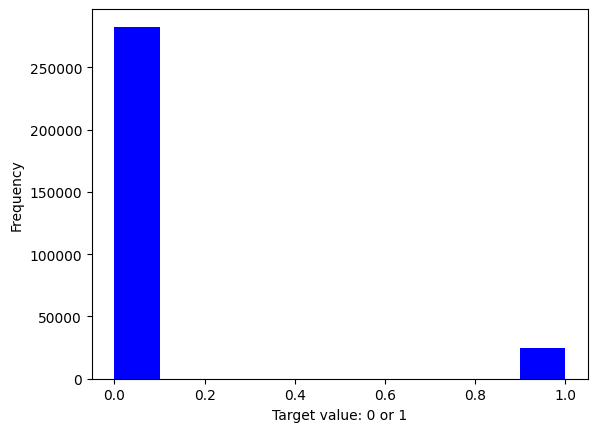

In [27]:
train_app['TARGET'].astype(int).plot.hist(color='blue').set_xlabel('Target value: 0 or 1');

count = train_app['TARGET'].value_counts()
num_repaid = count[0]
num_default = count[1]

print("Terdapat {} pinjaman yang dibayar tepat waktu (TARGET=0) dan {} yang gagal (TARGET=1) di dataset".format(num_repaid, num_default))

In [28]:
train_app.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [29]:
bureau.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [30]:
pos_cash_bal.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [31]:
inst_payment.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [32]:
credit_card_bal.isnull().sum()


SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

In [33]:
prev_app.isnull().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

In [34]:
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [35]:
def plot_bar_gen(feature, df = None, orientation_horizontal = True):

    if df is None:
        df = train_app
    else:
        df = df

    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    sns.set_color_codes("colorblind")

    if orientation_horizontal == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        s1 = sns.barplot(y = feature, x="Number of contracts",data=df1)
        plt.subplot(122)
        s2 = sns.barplot(y = feature, x='TARGET', data=cat_perc)
        plt.xlabel('Fraction of loans defaulted', fontsize=12)
        plt.ylabel(feature, fontsize=12)

    else:
        plt.figure(figsize=(10,18))
        plt.subplot(211)
        s1 = sns.barplot(x = feature, y="Number of contracts",data=df1)
        s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
        plt.subplot(212)
        s2 = sns.barplot(x = feature, y='TARGET', data=cat_perc)
        s2.set_xticklabels(s2.get_xticklabels(),rotation=90)
        plt.ylabel('Fraction of loans defaulted', fontsize=12)
        plt.xlabel(feature, fontsize=12)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.subplots_adjust(wspace = 0.6)
    plt.show();

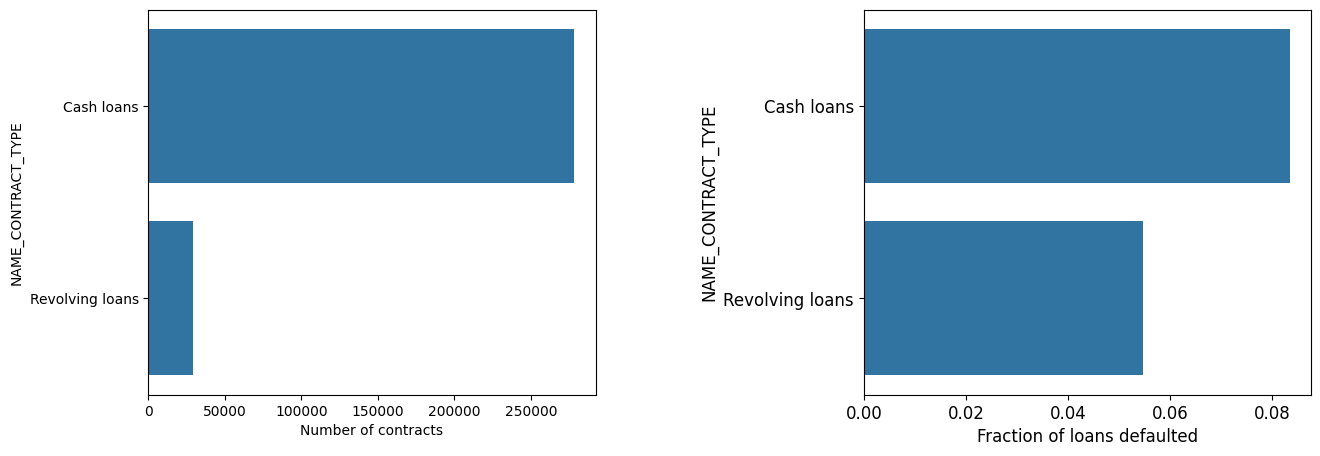

In [36]:
plot_bar_gen('NAME_CONTRACT_TYPE')

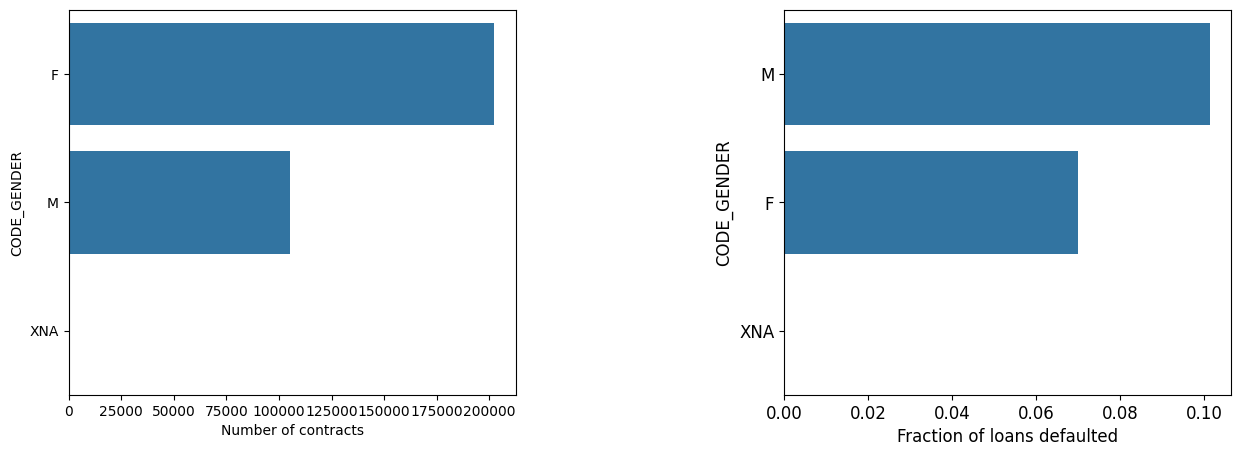

In [37]:
plot_bar_gen('CODE_GENDER')

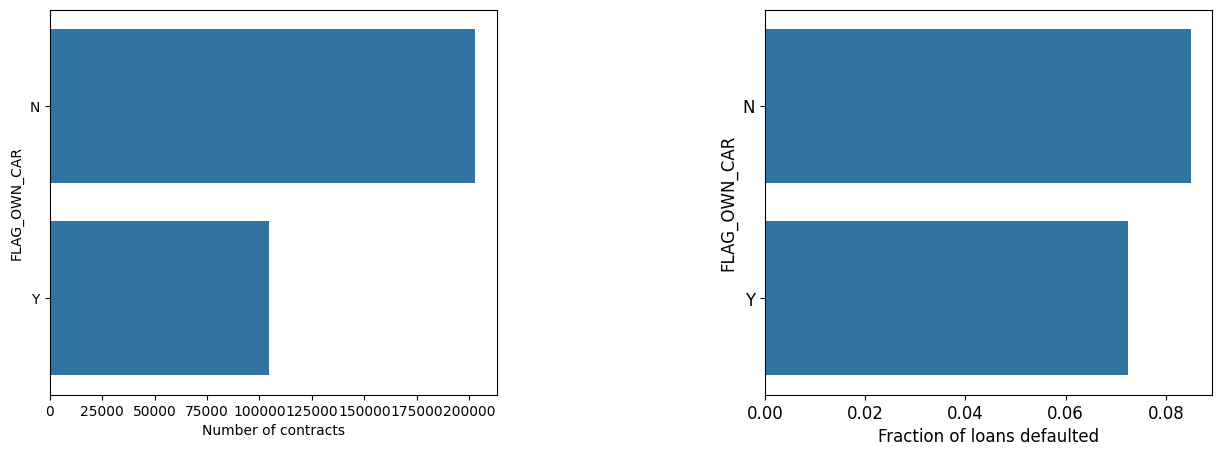

In [38]:
plot_bar_gen('FLAG_OWN_CAR')

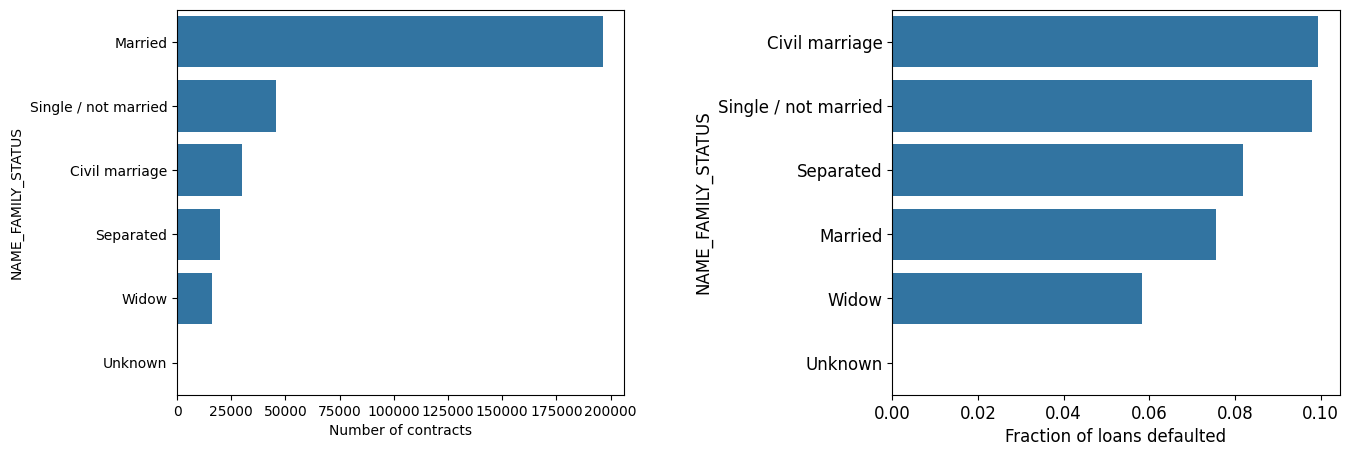

In [39]:
plot_bar_gen('NAME_FAMILY_STATUS')

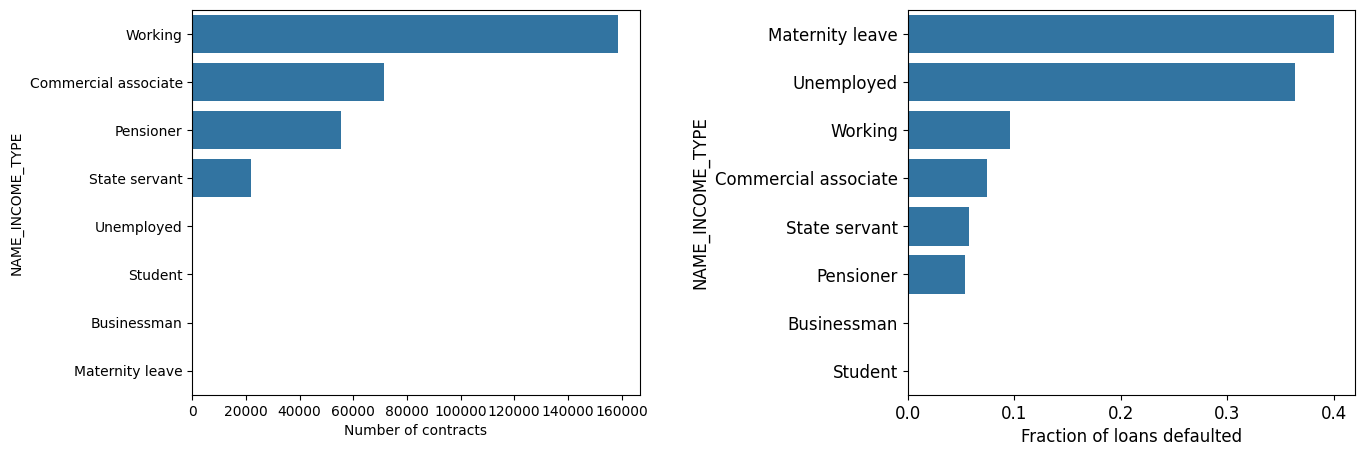

In [40]:
plot_bar_gen('NAME_INCOME_TYPE')

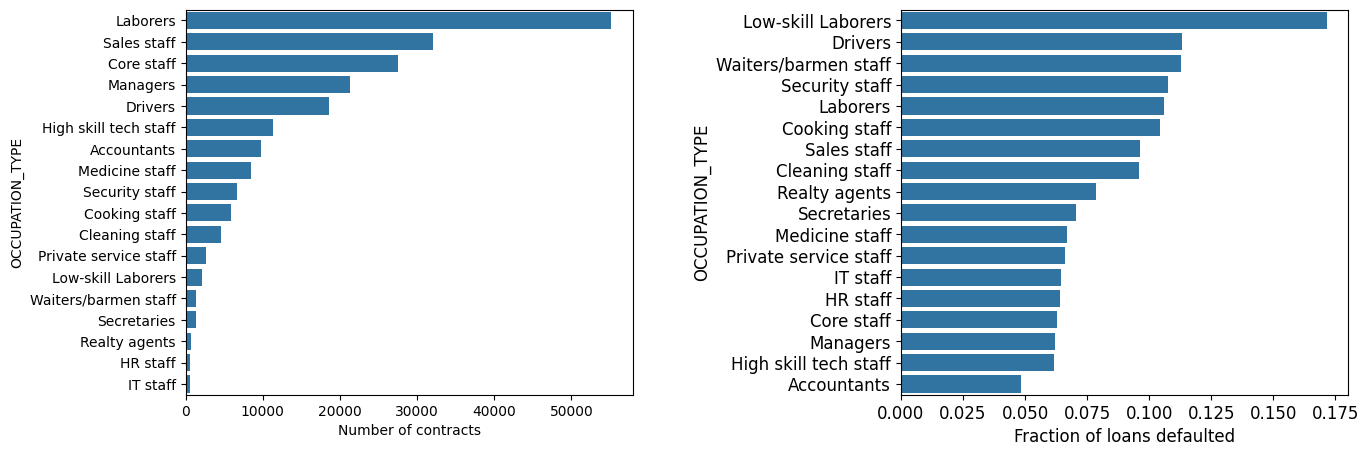

In [41]:
plot_bar_gen('OCCUPATION_TYPE')

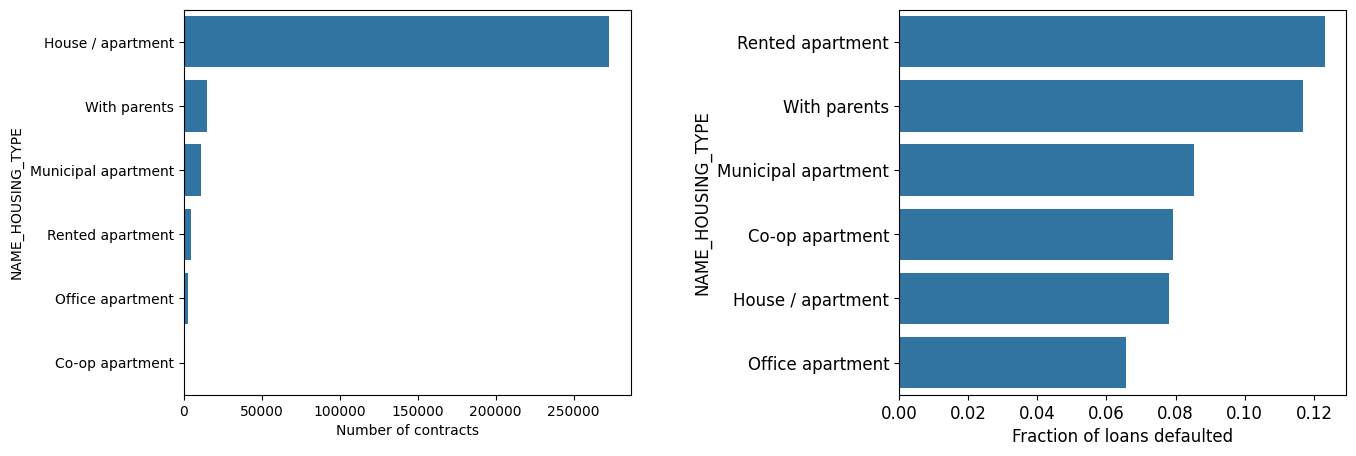

In [42]:
plot_bar_gen('NAME_HOUSING_TYPE')

In [43]:
# Plot distribution of one feature with or without paid/default shown separately

def plot_distribution_gen(feature,df=None,separate_target=False):
    if df is None:
        df = train_app
    else:
        df = df

    if separate_target == False:
        plt.figure(figsize=(10,6))
        plt.title("Distribution of %s" % feature)
        sns.distplot(df[feature].dropna(),color='red', kde=True,bins=100)
    else:
        t1 = df.loc[df['TARGET'] != 0]
        t0 = df.loc[df['TARGET'] == 0]

        plt.figure(figsize=(10,6))
        plt.title("Distribution of %s" % feature)
        sns.set_style('whitegrid')
#         sns.kdeplot(t1[feature], bw=0.5,label="Loan defaulted (TARGET=1)")
#         sns.kdeplot(t0[feature], bw=0.5,label="Loan repaid (TARGET = 0)")

        sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
        sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')

        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        plt.legend(loc="best", labels=['Loan repaid (TARGET=0)', 'Loan defaulted (TARGET=1)'])
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [44]:
def get_thresh(feature):
    """ Outliers are usually > 3 standard deviations away from the mean. """
    ave=np.mean(train_app[feature])
    sdev=np.std(train_app[feature])
    threshold=round(ave+(3*sdev),2)
    print('Threshold for',feature,':',threshold)
    return threshold

In [45]:
thresh_income = get_thresh('AMT_INCOME_TOTAL')
thresh_employment = get_thresh('DAYS_EMPLOYED')

anomalous_employment = train_app[train_app['DAYS_EMPLOYED'] > 0]
normal_employment = train_app[train_app['DAYS_EMPLOYED'] < 0]

print('The non-anomalies default on %0.2f%% of loans' % (100 * normal_employment['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anomalous_employment['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anomalous_employment))

Threshold for AMT_INCOME_TOTAL : 880166.2
Threshold for DAYS_EMPLOYED : 487641.66
The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [46]:
train_app['DAYS_EMPLOYED'].mask(train_app['DAYS_EMPLOYED'] > 0, inplace=True)
train_app['AMT_INCOME_TOTAL'].mask(train_app['AMT_INCOME_TOTAL'] > thresh_income, inplace=True)

In [47]:
def create_day_to_year(df,ls_cols,newcol):
    df[newcol] = round(np.abs(df[ls_cols[0]]/365))
    df.drop(columns=ls_cols,inplace=True);
    return df

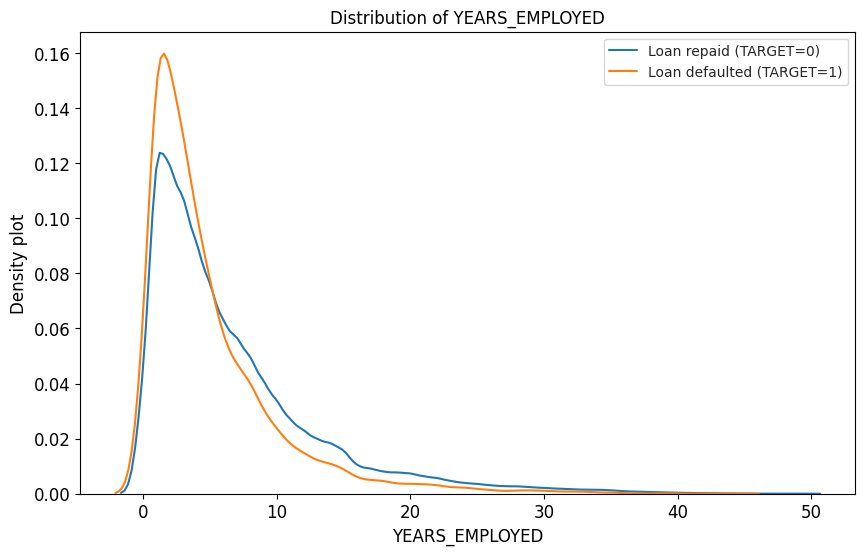

In [48]:
create_day_to_year(train_app,['DAYS_EMPLOYED'],'YEARS_EMPLOYED');
plot_distribution_gen('YEARS_EMPLOYED',None,True)

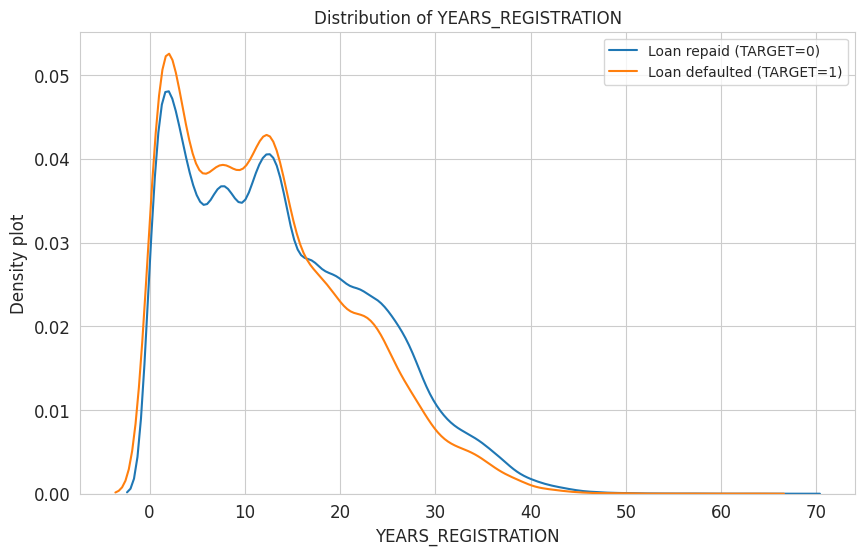

In [49]:
create_day_to_year(train_app,['DAYS_REGISTRATION'],'YEARS_REGISTRATION');
plot_distribution_gen('YEARS_REGISTRATION',None,True)

In [50]:
def create_income_band(df):
    df.loc[(df.AMT_INCOME_TOTAL < 30000),'INCOME_BAND'] = 1
    df.loc[(df.AMT_INCOME_TOTAL >= 30000)&(df.AMT_INCOME_TOTAL < 65000),'INCOME_BAND'] = 2
    df.loc[(df.AMT_INCOME_TOTAL >= 65000)&(df.AMT_INCOME_TOTAL < 95000),'INCOME_BAND'] = 3
    df.loc[(df.AMT_INCOME_TOTAL >= 95000)&(df.AMT_INCOME_TOTAL < 130000),'INCOME_BAND'] = 4
    df.loc[(df.AMT_INCOME_TOTAL >= 130000)&(df.AMT_INCOME_TOTAL < 160000),'INCOME_BAND'] = 5
    df.loc[(df.AMT_INCOME_TOTAL >= 160000)&(df.AMT_INCOME_TOTAL < 190000),'INCOME_BAND'] = 6
    df.loc[(df.AMT_INCOME_TOTAL >= 190000)&(df.AMT_INCOME_TOTAL < 220000),'INCOME_BAND'] = 7
    df.loc[(df.AMT_INCOME_TOTAL >= 220000)&(df.AMT_INCOME_TOTAL < 275000),'INCOME_BAND'] = 8
    df.loc[(df.AMT_INCOME_TOTAL >= 275000)&(df.AMT_INCOME_TOTAL < 325000),'INCOME_BAND'] = 9
    df.loc[(df.AMT_INCOME_TOTAL >= 325000),'INCOME_BAND'] = 10
    return df

In [51]:
application_bureau_train = train_app.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [52]:
application_prev_train = train_app.merge(prev_app, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

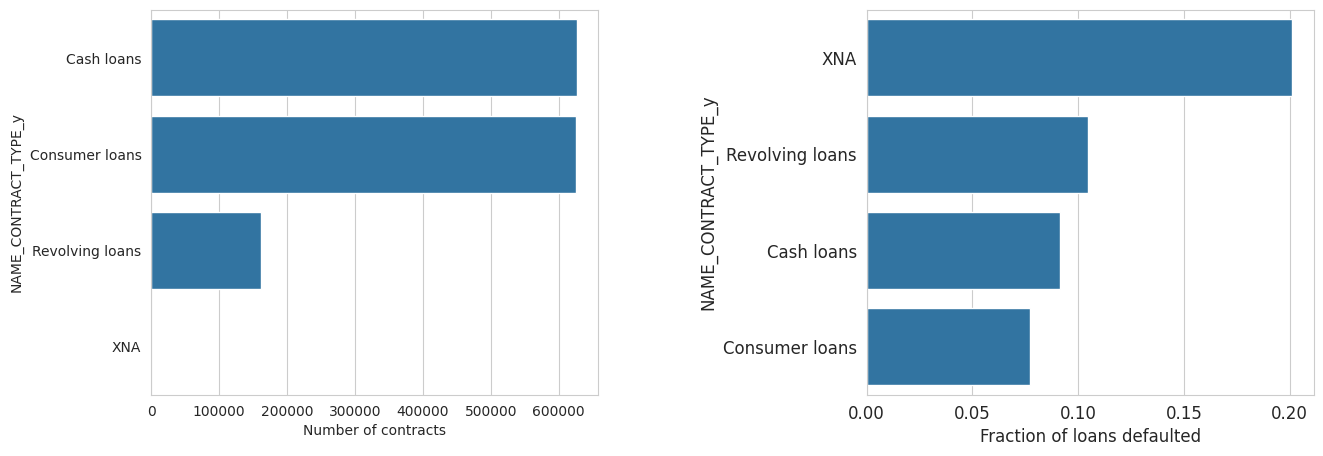

In [53]:
plot_bar_gen('NAME_CONTRACT_TYPE_y',application_prev_train)

### Feature engineering

In [54]:
save_files = False

if save_files == True:
    train_app.to_csv('train_app_updated.csv', index = False)
    bureau.to_csv('bureau_updated.csv', index = False)
    bureau_balance.to_csv('bureau_balance_updated.csv', index = False)
    credit_card_bal.to_csv('credit_card_bal.csv', index = False)
    inst_payment.to_csv('inst_payment_updated.csv', index = False)
    pos_cash_bal.to_csv('pos_cash_bal_updated.csv', index = False)
    prev_app.to_csv('prev_app_updated.csv', index = False)

In [55]:
load_files = False  # Existing variables in memory

if load_files == False:
    train_app_new = train_app.copy()
    bureau_new = bureau.copy()
    bureau_balance_new = bureau_balance.copy()
    credit_card_balance_new = credit_card_bal.copy()
    installments_payments_new = inst_payment.copy()
    pos_cash_balance_new = pos_cash_bal.copy()
    previous_application_new = prev_app.copy()

    gc.enable()
    del train_app, bureau, bureau_balance, credit_card_bal, inst_payment, pos_cash_bal, prev_app
    gc.collect()

else:
    application_train_new = pd.read_csv("train_app_updated.csv")
    bureau_new = pd.read_csv("bureau_updated.csv")
    bureau_balance_new  = pd.read_csv("bureau_balance_updated.csv")
    credit_card_balance_new  = pd.read_csv("credit_card_bal.csv")
    installments_payments_new = pd.read_csv("inst_payment_updated.csv")
    pos_cash_balance_new = pd.read_csv("pos_cash_bal_updated.csv")
    previous_application_new  = pd.read_csv("prev_app_updated.csv")

In [56]:
def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

In [57]:
train_app_new = replace_day_outliers(train_app_new)
bureau_new = replace_day_outliers(bureau_new )
bureau_balance_new  = replace_day_outliers(bureau_balance_new)
credit_card_balance_new  = replace_day_outliers(credit_card_balance_new)
installments_payment_new = replace_day_outliers(installments_payments_new )
pos_cash_balance_new = replace_day_outliers(pos_cash_balance_new )
previous_application_new  = replace_day_outliers(previous_application_new )

In [58]:
#Function for removing columns with missing values more than 60%

def remove_missing_col(df):
    miss_data = pd.DataFrame((df.isnull().sum())*100/df.shape[0])
    miss_data_col=miss_data[miss_data[0]>60].index
    data_new  = df[[i for i in df.columns if i not in miss_data_col]]
    return data_new

In [59]:
#Custom imputer for numerical and categorical variables (https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn)

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value
        in column.

        Columns of other types are imputed with median of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [60]:
# one-hot encoding of categorical variables
base_case_train = pd.get_dummies(train_app_new)

In [61]:
# Drop the SK_ID from the training data
skid_temp = train_app_new['SK_ID_CURR']
train = base_case_train.drop(columns = ['SK_ID_CURR'])

# Feature names
features = list(train.columns)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Median imputation of missing values
train = DataFrameImputer().fit_transform(train)

## Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
base_case_train = pd.DataFrame(data=train, columns=features)

print('Data shape: ', base_case_train.shape)

Data shape:  (307511, 245)


In [62]:
base_case_train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,...,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1.0,0.0,0.207607,0.090287,0.090032,0.077441,0.256321,0.888839,0.705433,0.098901,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.286846,0.311736,0.132924,0.271605,0.045016,0.477114,0.959566,0.098901,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.0,0.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.312933,0.727773,0.597163,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.049128,0.022472,0.020025,0.023569,0.134897,0.348534,0.648326,0.285714,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.518318,0.650190,0.814130,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0481,0.0756,0.0745,0.0000,0.0036,0.0840,0.0746,0.9816,0.7648,0.0190,0.0000,0.1379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.128368,0.066837,0.

In [63]:
base_case_train['SK_ID_CURR'] = skid_temp

print('Data shape: ', base_case_train.shape)

Data shape:  (307511, 246)


In [64]:
# Train-Test split -- temporary
# Logistic regression - sanity check

#splitting application_train_newdf into train and test
train,test = train_test_split(base_case_train,test_size=.25,random_state = 123)

#separating dependent and independent variables
train_X = train[[i for i in train.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
train_Y = train[["TARGET"]]

test_X  = test[[i for i in test.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
test_Y  = test[["TARGET"]]

In [65]:
#Model function

def model_base(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    # Extract feature names
    feature_names = list(dtrain_X.columns)
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]

    # Record the feature importances
    feature_importance_values= algorithm.coef_[0]
    feature_importance_values = np.absolute(feature_importance_values)
#     # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    print (algorithm)
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)

    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    return feature_importances

LogisticRegression()
Accuracy score :  0.9183771690210464
classification report :
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     76744
         1.0       0.01      0.48      0.02       134

    accuracy                           0.92     76878
   macro avg       0.50      0.70      0.49     76878
weighted avg       1.00      0.92      0.96     76878



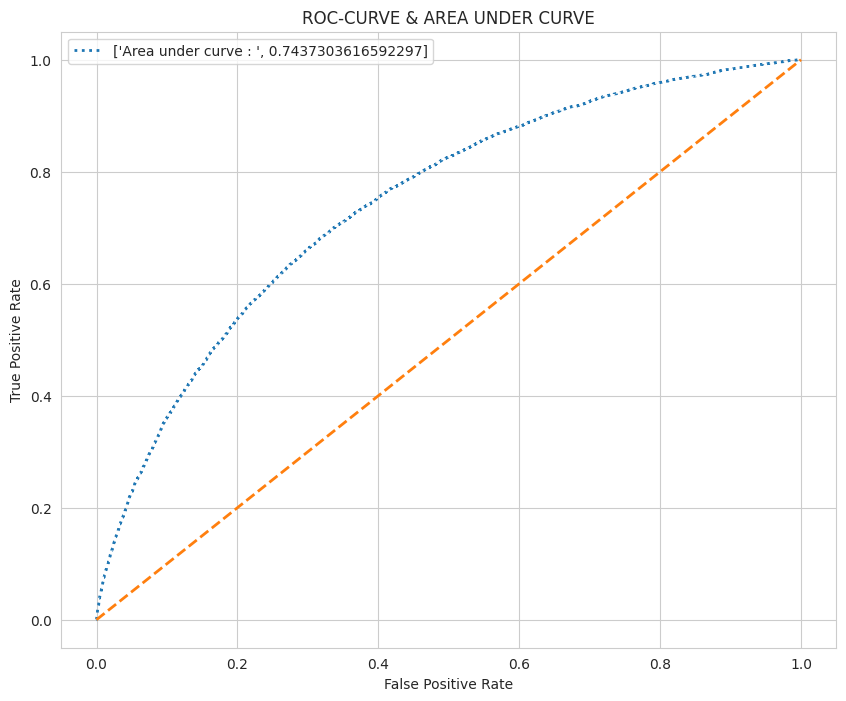

In [66]:
logit = LogisticRegression()
feature_importances_logit_base = model_base(logit,train_X,train_Y,test_X,test_Y,train_X.columns)

In [67]:
#Domain knowledge

train_app_new['CREDIT_INCOME_PERCENT'] = train_app_new['AMT_CREDIT'] / train_app_new['AMT_INCOME_TOTAL']
train_app_new['ANNUITY_INCOME_PERCENT'] = train_app_new['AMT_ANNUITY'] / train_app_new['AMT_INCOME_TOTAL']
train_app_new['CREDIT_TERM'] = train_app_new['AMT_ANNUITY'] / train_app_new['AMT_CREDIT']


In [7]:
!pip install featuretools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.1/620.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 26.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [9]:
# Iterate through the columns and record the Boolean columns
import featuretools as ft
from featuretools import selection
def bool_type(df):

    col_type = {}

    for col in df:
        # If column is a number with only two values, encode it as a Boolean
        if (df[col].dtype != 'object') and (len(df[col].unique()) <= 2):
            col_type[col] = ft.variable_types.Boolean

    print('Number of boolean variables: ', len(col_type))
    return col_type